# 1. Data Preparation

### Import libraries

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
np.random.seed(12049)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_path = "/content/drive/MyDrive/knee_oa_project"
zip_path = "/content/drive/MyDrive/KneeXrayData.zip"
extract_path = f"{project_path}/dataset"

if not os.path.exists(project_path):
    os.makedirs(project_path)
    print("Created project folder:", project_path)
else:
    print("Project folder already exists:", project_path)

if not os.path.exists(zip_path):
    raise FileNotFoundError(
        f"ZIP file not found at: {zip_path}\n"
        "Please upload KneeXrayData.zip to your Google Drive."
    )
else:
    print("Found dataset ZIP:", zip_path)

if not os.path.exists(extract_path) or len(os.listdir(extract_path)) == 0:
    if not os.path.exists(extract_path):
        os.makedirs(extract_path)
        print("Created dataset extraction folder:", extract_path)

    print("Extracting ZIP file. This may take several minutes...")
    !unzip -q "{zip_path}" -d "{extract_path}"
    print("Extraction completed.")
else:
    print("Dataset already extracted. Skipping extraction.")

Project folder already exists: /content/drive/MyDrive/knee_oa_project
Found dataset ZIP: /content/drive/MyDrive/KneeXrayData.zip
Dataset already extracted. Skipping extraction.


In [ ]:
base = "/content/drive/MyDrive/knee_oa_project/dataset"

for root, dirs, files in os.walk(base):
    if "train" in dirs and "val" in dirs and "test" in dirs:
        print("Found the folder that contains train/val/test:")
        print(root)
        break

Found the folder that contains train/val/test:
/content/drive/MyDrive/knee_oa_project/dataset/KneeXrayData/ClsKLData/kneeKL299


In [ ]:
train_dir = "/content/drive/MyDrive/knee_oa_project/dataset/KneeXrayData/ClsKLData/kneeKL224/train"
val_dir   = "/content/drive/MyDrive/knee_oa_project/dataset/KneeXrayData/ClsKLData/kneeKL224/val"
test_dir  = "/content/drive/MyDrive/knee_oa_project/dataset/KneeXrayData/ClsKLData/kneeKL224/test"

print("Train path:", train_dir)
print("Val path:", val_dir)
print("Test path:", test_dir)

Train path: /content/drive/MyDrive/knee_oa_project/dataset/KneeXrayData/ClsKLData/kneeKL224/train
Val path: /content/drive/MyDrive/knee_oa_project/dataset/KneeXrayData/ClsKLData/kneeKL224/val
Test path: /content/drive/MyDrive/knee_oa_project/dataset/KneeXrayData/ClsKLData/kneeKL224/test


In [ ]:
def get_classes(data_path, classes, data):
    print(f"---- {data} ----")
    knee_severity = {}
    count = 0

    for i in range(len(classes)):
        imgs = os.listdir(os.path.join(data_path, str(i)))
        knee_severity[i] = imgs
        count += len(imgs)

    for k, v in knee_severity.items():
        print(
            f"Grade {k} - {classes[k]}: {len(v)} images, {round((len(v) * 100) / count, 2)}%"
        )

    return knee_severity


def plot_classes(dict_classes, data_path, classes, data):
    for k, v in dict_classes.items():
        print(f"{data} - {classes[k]}")
        plt.figure(figsize=(10, 25))
        for i in range(5):
            img_path = os.path.join(data_path, str(k), v[i])
            img = tf.keras.preprocessing.image.load_img(img_path)
            plt.subplot(1, 5, 1 + i, xticks=[], yticks=[])
            plt.imshow(img)
            plt.title(f"Grade {k}")
        plt.show()

## Load data

In [ ]:
# Class names
class_names = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

In [ ]:
base_dir = "../dataset/"
train_path = train_dir
valid_path = val_dir
test_path = test_dir

In [ ]:
train_data = get_classes(train_dir, class_names, 'Train')
valid_data = get_classes(val_dir, class_names, 'Valid')
tests_data = get_classes(test_dir, class_names, 'Test')

---- Train ----
Grade 0 - Healthy: 2286 images, 39.56%
Grade 1 - Doubtful: 1046 images, 18.1%
Grade 2 - Minimal: 1516 images, 26.24%
Grade 3 - Moderate: 757 images, 13.1%
Grade 4 - Severe: 173 images, 2.99%
---- Valid ----
Grade 0 - Healthy: 328 images, 39.71%
Grade 1 - Doubtful: 153 images, 18.52%
Grade 2 - Minimal: 212 images, 25.67%
Grade 3 - Moderate: 106 images, 12.83%
Grade 4 - Severe: 27 images, 3.27%
---- Test ----
Grade 0 - Healthy: 639 images, 38.59%
Grade 1 - Doubtful: 296 images, 17.87%
Grade 2 - Minimal: 447 images, 26.99%
Grade 3 - Moderate: 223 images, 13.47%
Grade 4 - Severe: 51 images, 3.08%


In [ ]:
import hashlib
from collections import defaultdict

def find_duplicates(dataset_dir):
    image_hashes = defaultdict(list)
    duplicates = {}

    print(f"Checking for duplicates in: {dataset_dir}")
    for class_folder in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_folder)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                if os.path.isfile(image_path):
                    with open(image_path, 'rb') as f:
                        file_hash = hashlib.md5(f.read()).hexdigest()
                    image_hashes[file_hash].append(image_path)

    for file_hash, paths in image_hashes.items():
        if len(paths) > 1:
            duplicates[file_hash] = paths

    if duplicates:
        print(f"Found {len(duplicates)} groups of duplicate images.")
        for file_hash, paths in duplicates.items():
            print(f"  Hash: {file_hash}")
            for p in paths:
                print(f"    - {p}")
    else:
        print("No exact duplicate images found.")
    return duplicates

print("--- Checking Training Data ---")
train_duplicates = find_duplicates(train_dir)
print("\n--- Checking Validation Data ---")
val_duplicates = find_duplicates(val_dir)
print("\n--- Checking Test Data ---")
test_duplicates = find_duplicates(test_dir)

print("\n--- Cross-dataset Duplication Check ---")
def find_cross_duplicates(dir1, dir2, name1, name2):
    hashes1 = {}
    for class_folder in os.listdir(dir1):
        class_path = os.path.join(dir1, class_folder)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                if os.path.isfile(image_path):
                    with open(image_path, 'rb') as f:
                        hashes1[hashlib.md5(f.read()).hexdigest()] = image_path

    cross_duplicates = []
    for class_folder in os.listdir(dir2):
        class_path = os.path.join(dir2, class_folder)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                if os.path.isfile(image_path):
                    with open(image_path, 'rb') as f:
                        file_hash = hashlib.md5(f.read()).hexdigest()
                    if file_hash in hashes1:
                        cross_duplicates.append((image_path, hashes1[file_hash]))

    if cross_duplicates:
        print(f"Found {len(cross_duplicates)} duplicates between {name1} and {name2}.")
        for path2, path1 in cross_duplicates:
            print(f"  - {path1} (in {name1}) is a duplicate of {path2} (in {name2})")
    else:
        print(f"No duplicates found between {name1} and {name2}.")
    return cross_duplicates


train_val_cross_duplicates = find_cross_duplicates(train_dir, val_dir, 'Train', 'Valid')
train_test_cross_duplicates = find_cross_duplicates(train_dir, test_dir, 'Train', 'Test')
val_test_cross_duplicates = find_cross_duplicates(val_dir, test_dir, 'Valid', 'Test')

--- Checking Training Data ---
Checking for duplicates in: /content/drive/MyDrive/knee_oa_project/dataset/KneeXrayData/ClsKLData/kneeKL224/train
No exact duplicate images found.

--- Checking Validation Data ---
Checking for duplicates in: /content/drive/MyDrive/knee_oa_project/dataset/KneeXrayData/ClsKLData/kneeKL224/val
No exact duplicate images found.

--- Checking Test Data ---
Checking for duplicates in: /content/drive/MyDrive/knee_oa_project/dataset/KneeXrayData/ClsKLData/kneeKL224/test
No exact duplicate images found.

--- Cross-dataset Duplication Check ---
No duplicates found between Train and Valid.
No duplicates found between Train and Test.
No duplicates found between Valid and Test.


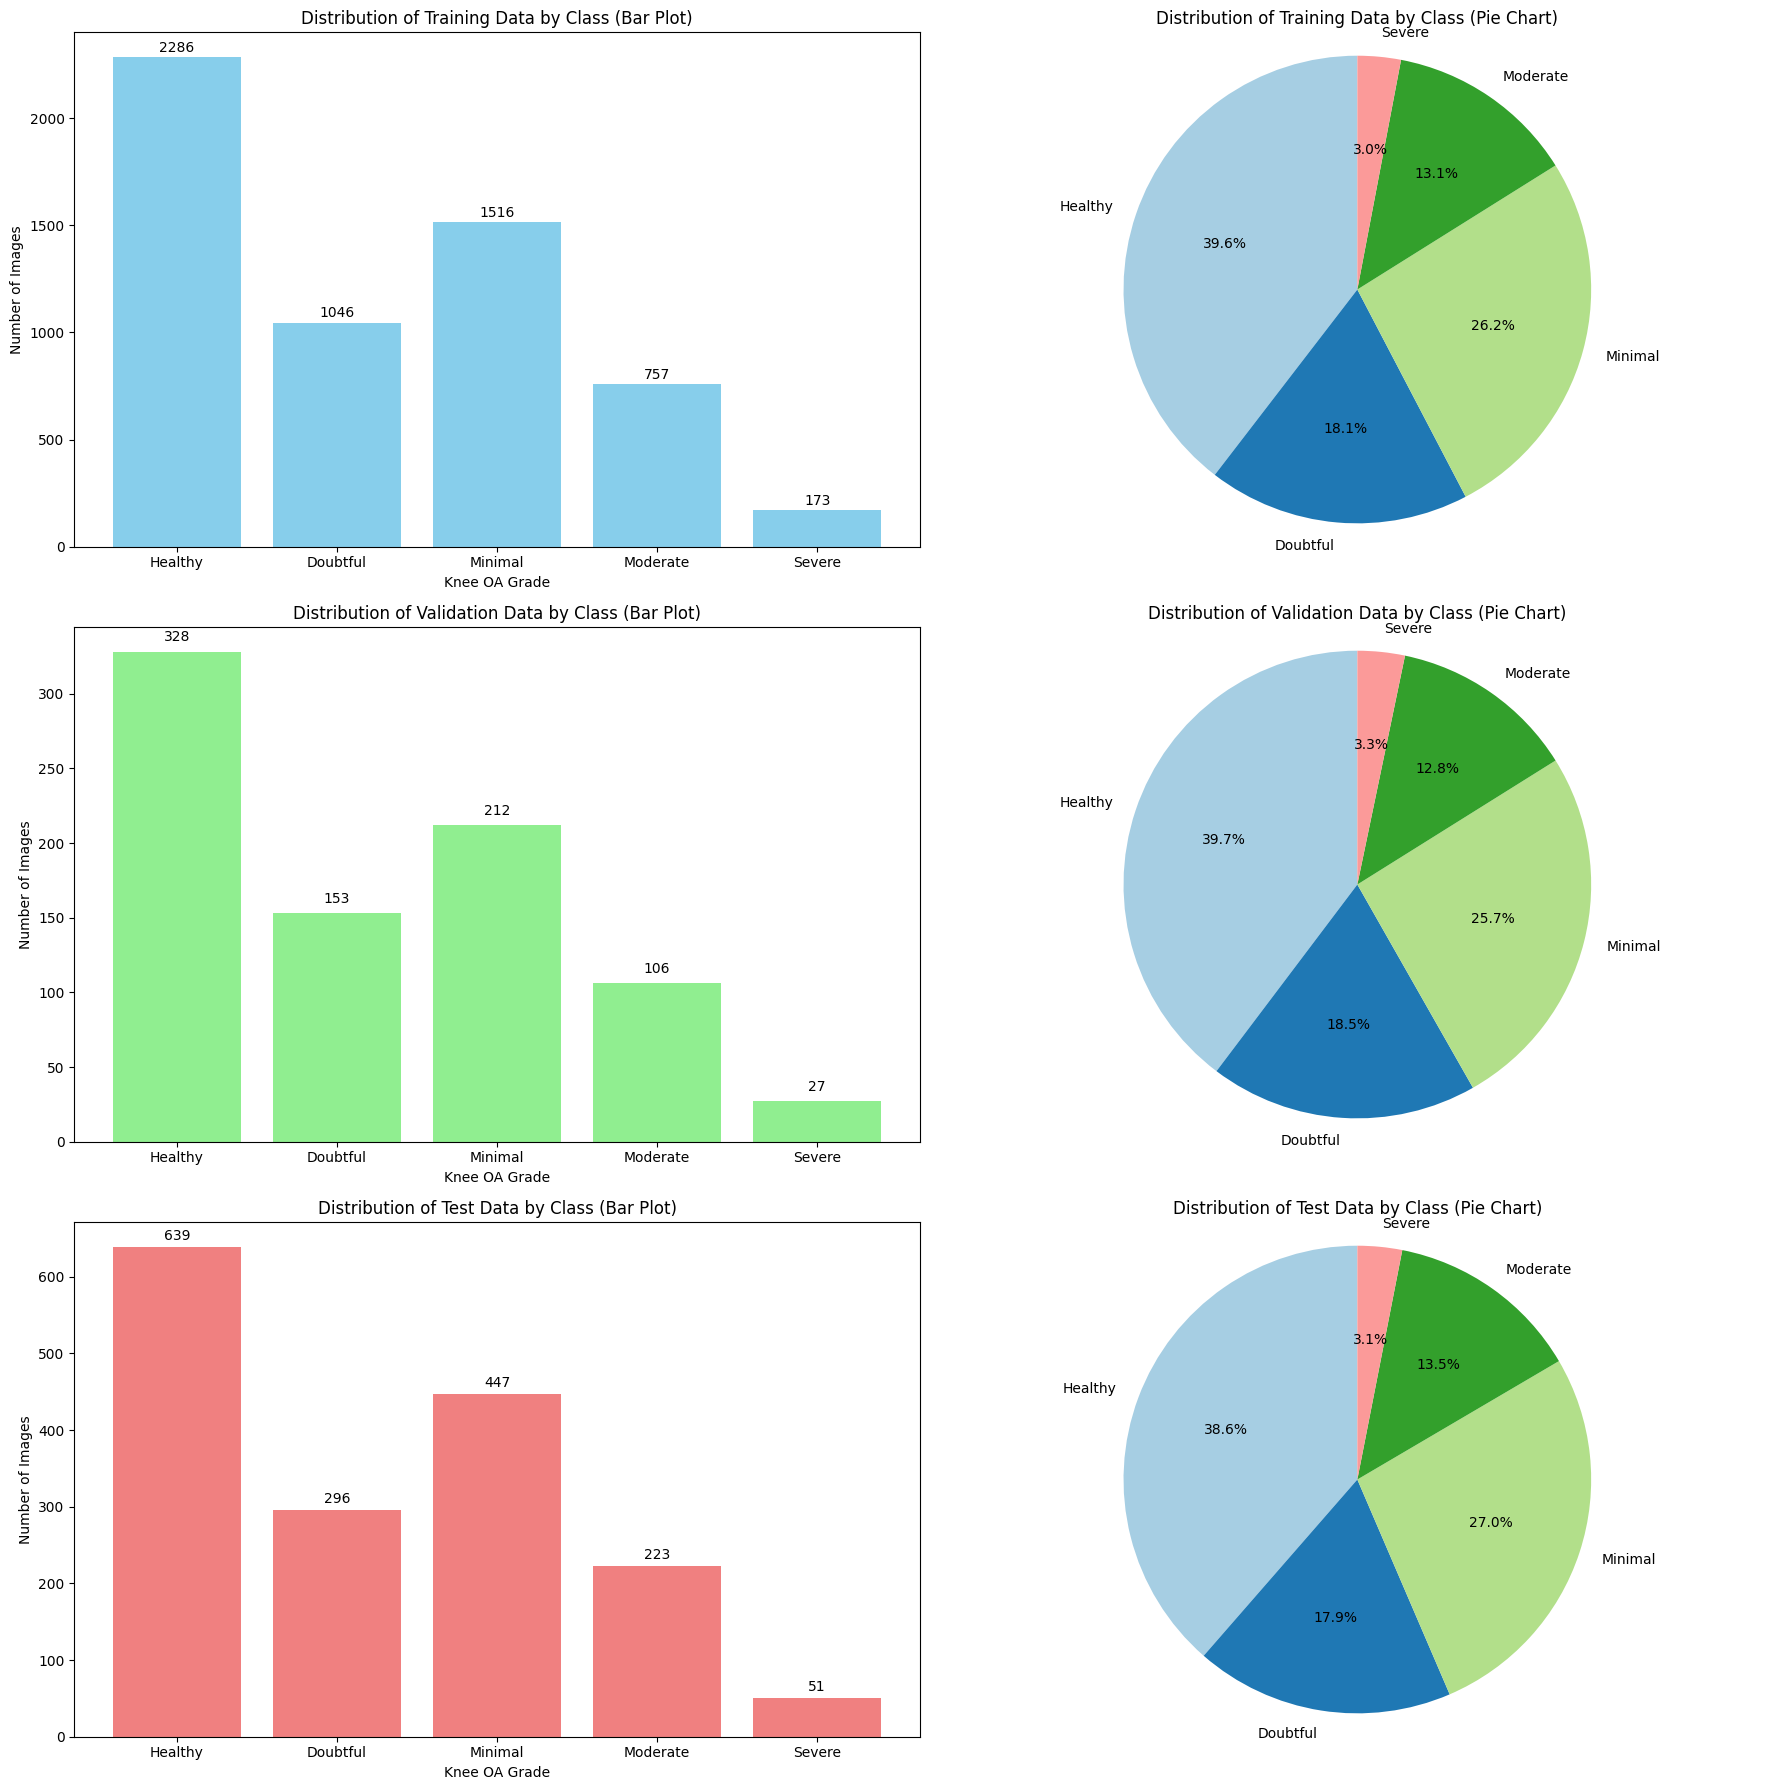

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

# --- Training Data --- #
# Bar Plot for Training Data
axes[0, 0].bar(class_names, counts, color='skyblue')
axes[0, 0].set_xlabel('Knee OA Grade')
axes[0, 0].set_ylabel('Number of Images')
axes[0, 0].set_title('Distribution of Training Data by Class (Bar Plot)')
for i, count in enumerate(counts):
    axes[0, 0].text(i, count + 10, str(count), ha='center', va='bottom')

# Pie Chart for Training Data
axes[0, 1].pie(percentages, labels=class_names, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
axes[0, 1].set_title('Distribution of Training Data by Class (Pie Chart)')
axes[0, 1].axis('equal')

# --- Validation Data --- #
valid_percentages = [(count / sum(valid_counts)) * 100 for count in valid_counts]

# Bar Plot for Validation Data
axes[1, 0].bar(class_names, valid_counts, color='lightgreen')
axes[1, 0].set_xlabel('Knee OA Grade')
axes[1, 0].set_ylabel('Number of Images')
axes[1, 0].set_title('Distribution of Validation Data by Class (Bar Plot)')
for i, count in enumerate(valid_counts):
    axes[1, 0].text(i, count + 5, str(count), ha='center', va='bottom')

# Pie Chart for Validation Data
axes[1, 1].pie(valid_percentages, labels=class_names, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
axes[1, 1].set_title('Distribution of Validation Data by Class (Pie Chart)')
axes[1, 1].axis('equal')

# --- Test Data --- #
test_percentages = [(count / sum(test_counts)) * 100 for count in test_counts]

# Bar Plot for Test Data
axes[2, 0].bar(class_names, test_counts, color='lightcoral')
axes[2, 0].set_xlabel('Knee OA Grade')
axes[2, 0].set_ylabel('Number of Images')
axes[2, 0].set_title('Distribution of Test Data by Class (Bar Plot)')
for i, count in enumerate(test_counts):
    axes[2, 0].text(i, count + 5, str(count), ha='center', va='bottom')

# Pie Chart for Test Data
axes[2, 1].pie(test_percentages, labels=class_names, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
axes[2, 1].set_title('Distribution of Test Data by Class (Pie Chart)')
axes[2, 1].axis('equal')
plt.tight_layout()
plt.show()

## Visualize data

### Train data

Train data - Healthy


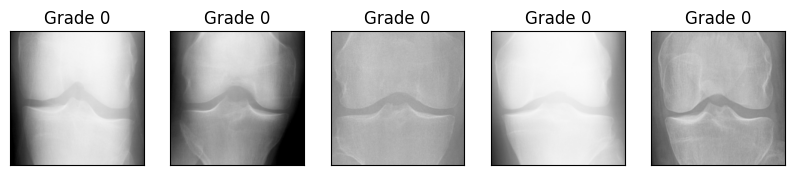

Train data - Doubtful


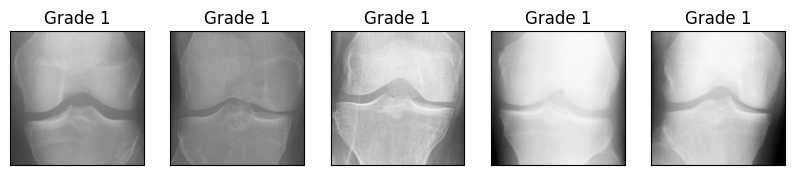

Train data - Minimal


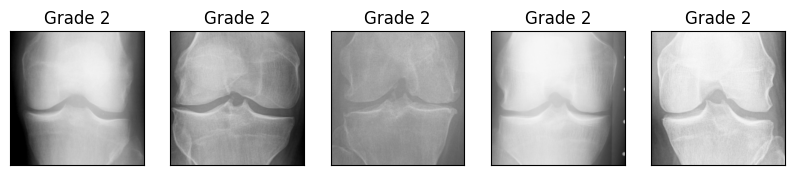

Train data - Moderate


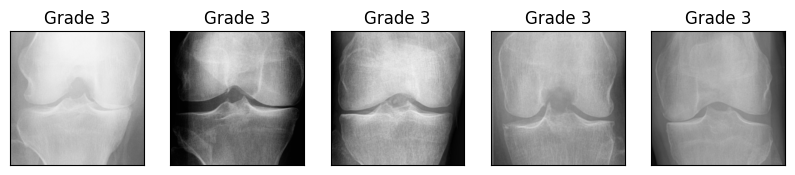

Train data - Severe


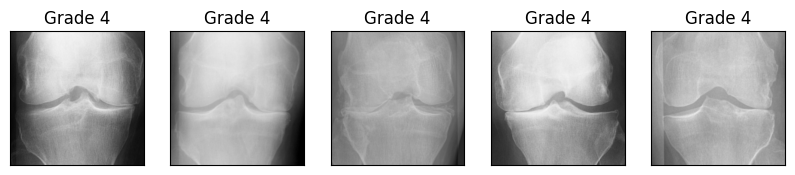

In [ ]:
plot_classes(train_data, train_path, class_names, 'Train data')

### Valid data

Valid data - Healthy


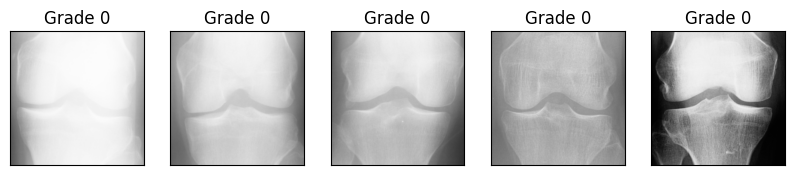

Valid data - Doubtful


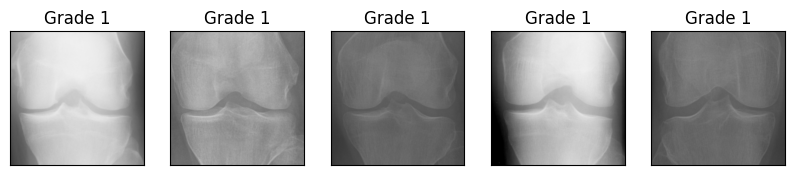

Valid data - Minimal


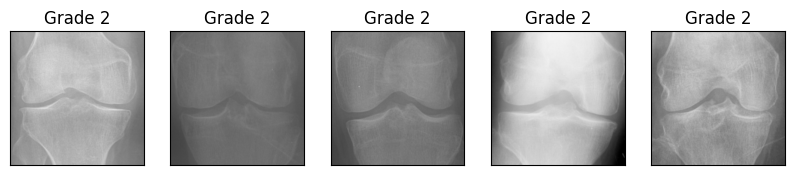

Valid data - Moderate


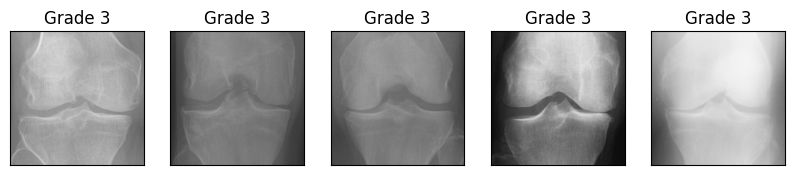

Valid data - Severe


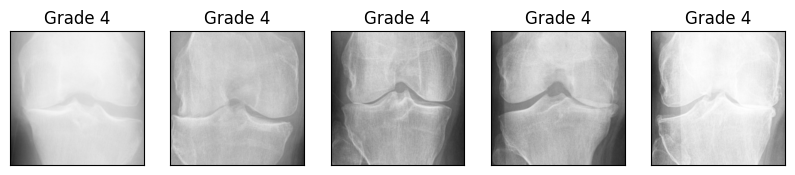

In [ ]:
plot_classes(valid_data, valid_path, class_names, 'Valid data')

### Test data

Test data - Healthy


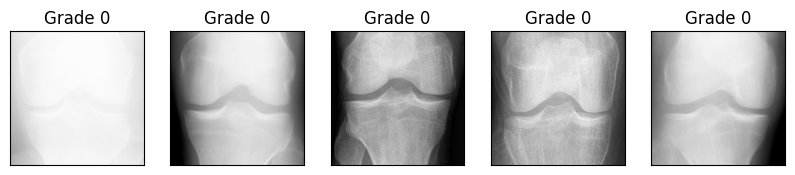

Test data - Doubtful


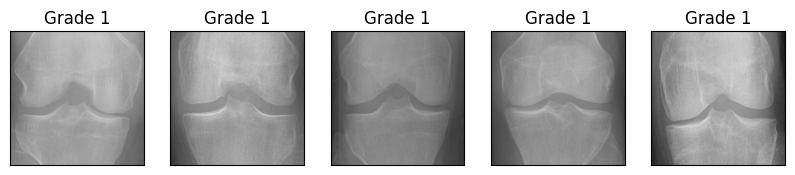

Test data - Minimal


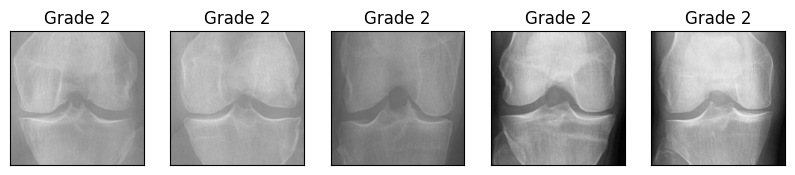

Test data - Moderate


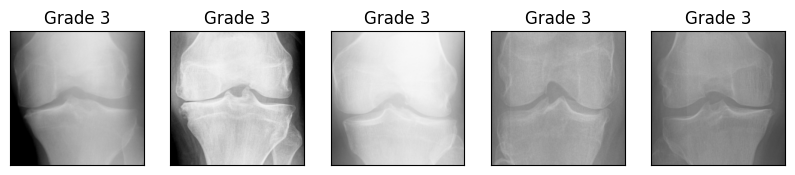

Test data - Severe


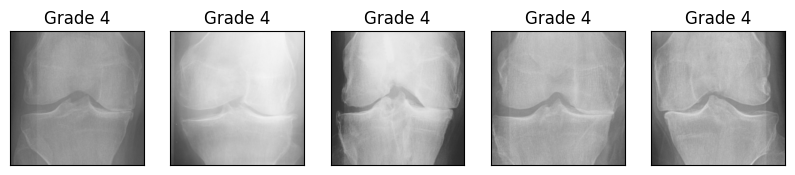

In [ ]:
plot_classes(tests_data, test_path, class_names, 'Test data')

## Image Data Generator Examples

#### brightness_range

Found 5778 images belonging to 5 classes.


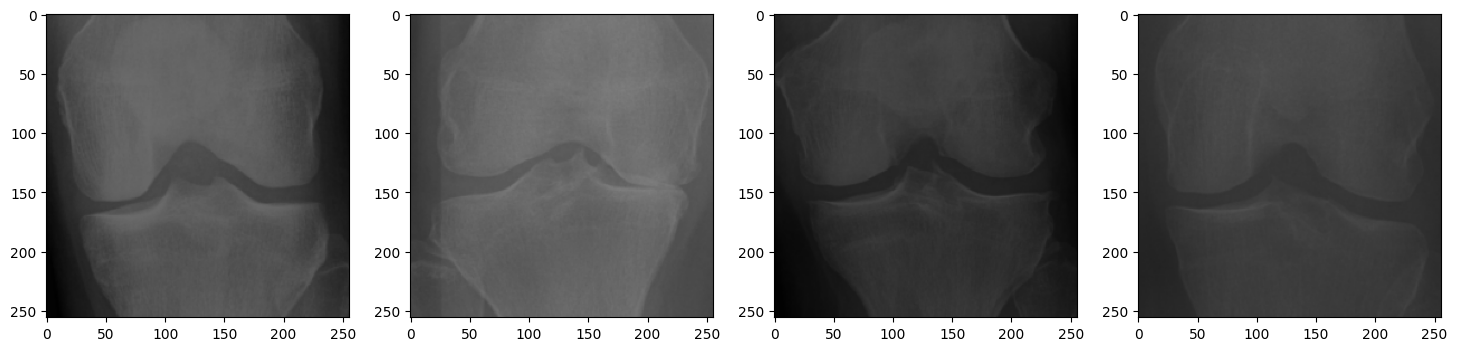

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    brightness_range=[0.3, 0.8]
)
imagegen = datagen.flow_from_directory(train_path, batch_size=1)
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))
for row in rows:
    row.imshow(next(imagegen)[0][0].astype("uint8"))
plt.show()

#### width_shift_range

Found 5778 images belonging to 5 classes.


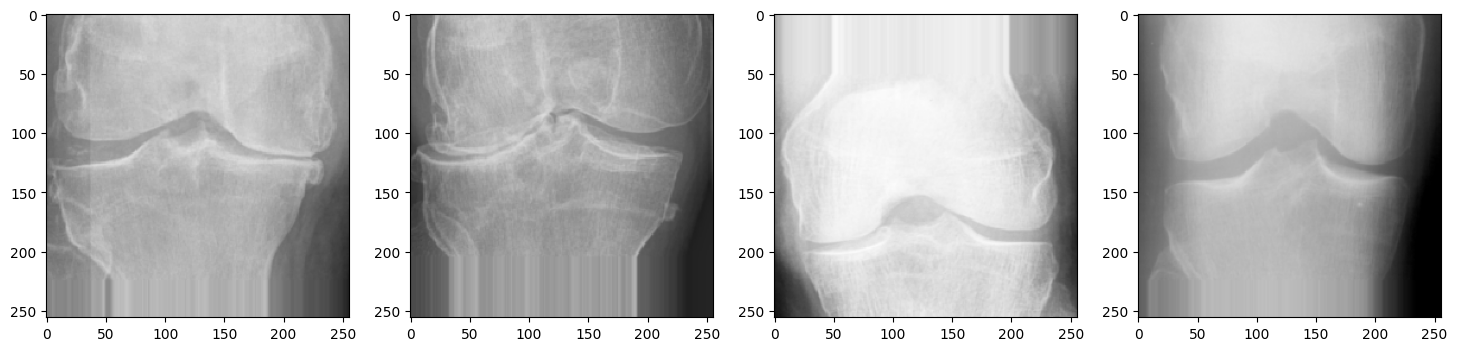

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=[-50,0,50,30,-30]
)
imagegen = datagen.flow_from_directory(train_path, batch_size=5)
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18,18))
for row in rows:
    row.imshow(next(imagegen)[0][0].astype('uint8'))
plt.show()

#### zoom_range

Found 5778 images belonging to 5 classes.


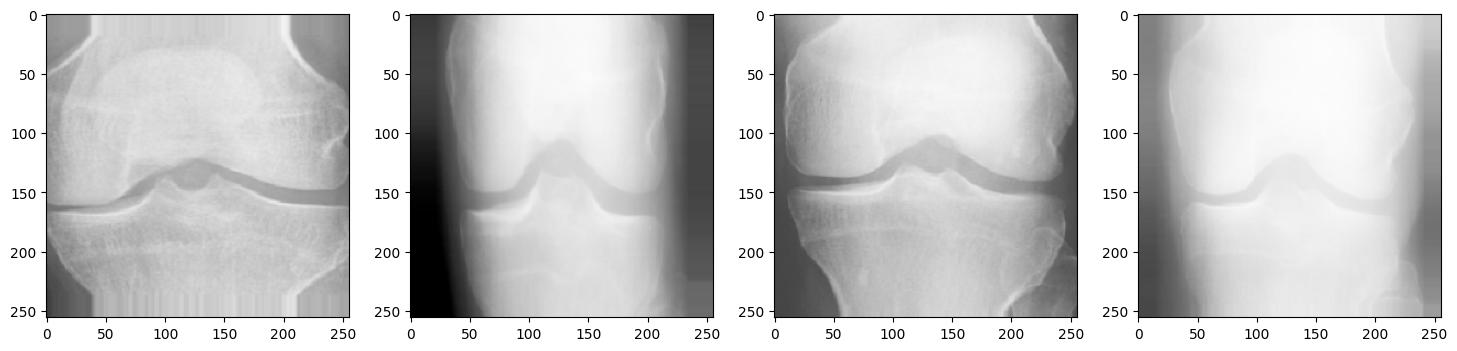

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    zoom_range=0.2
)
imagegen = datagen.flow_from_directory(train_path, batch_size=1)
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18,18))
for row in rows:
    row.imshow(next(imagegen)[0][0].astype("uint8"))
plt.show()

#### horizontal_flip

Found 5778 images belonging to 5 classes.


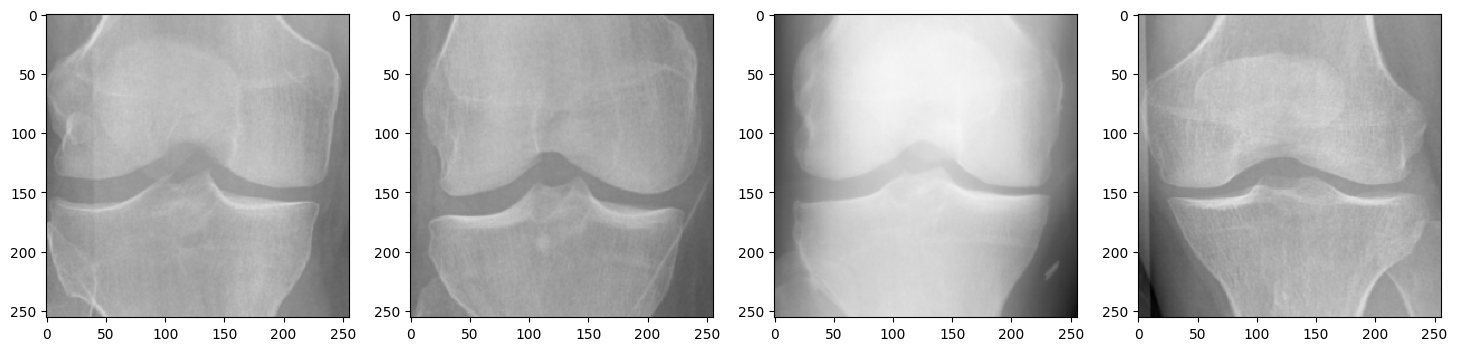

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True
)
imagegen = datagen.flow_from_directory(train_path, batch_size=1)
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18,18))
for row in rows:
    row.imshow(next(imagegen)[0][0].astype("uint8"))
plt.show()

## Image Data Generator and Preprocess

In [ ]:
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    width_shift_range=[-50, 0, 50, 30, -30],
    zoom_range=0.1,
    fill_mode="nearest",
)

noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)

In [ ]:
target_size = (224, 224)

train_generator = aug_datagen.flow_from_directory(
    train_path, class_mode="categorical", target_size=target_size, shuffle=True
)

valid_generator = noaug_datagen.flow_from_directory(
    valid_path,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.


In [ ]:
y_train = train_generator.labels
y_val = valid_generator.labels

## Class weight

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
print("Train ---> ", dict(zip(unique, counts)))

class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
train_class_weights = dict(enumerate(class_weights))
print(train_class_weights)

Train --->  {np.int32(0): np.int64(2286), np.int32(1): np.int64(1046), np.int32(2): np.int64(1516), np.int32(3): np.int64(757), np.int32(4): np.int64(173)}
{0: np.float64(0.5055118110236221), 1: np.float64(1.1047801147227534), 2: np.float64(0.7622691292875989), 3: np.float64(1.5265521796565389), 4: np.float64(6.679768786127168)}
